## Import Required Libraries

In [24]:
import numpy as np
from numpy import linalg as LA
from statsmodels.distributions.empirical_distribution import ECDF
from ipynb.fs.full.UUtest import *

## UniSplit method

In [26]:
def F(ecdf, v):
    """
    Returns the ECDF value at a given point v.

    Parameters:
    - ecdf: ECDF object with attributes .x and .y
    - v: value at which to evaluate the ECDF

    Returns:
    - The ECDF value at point v
    """
    ind_v = np.where(ecdf.x == v)[0][0]
    return ecdf.y[ind_v]


def focus_in_interval(X, interval, all_intervals):
    """
    Recursively refines the given interval if it fails the UUtest,
    collecting all non-unimodal-uniform (non-UU) subintervals.

    Parameters:
    - X: list of 1D data points
    - interval: current interval to examine [a, b]
    - all_intervals: list to collect non-UU intervals

    Returns:
    - interval: current (possibly updated) interval
    - all_intervals: updated list of all non-unimodal intervals
    """
    D = [x for x in X if interval[0] <= x <= interval[1]]
    S, notUU, _, _ = UUtest(D)
    
    if S:  # If the interval is unimodal, keep it
        all_intervals.append(interval)
        return interval, all_intervals

    if interval == notUU[0]:  # If it failed as a whole
        all_intervals.append(interval)
        return interval, all_intervals        

    # Otherwise recursively examine subintervals
    for inter in notUU:
        interval, all_intervals = focus_in_interval(X, inter, all_intervals)
    return interval, all_intervals


def detect_candidate_splitting_intervals(X):
    """
    Detects all candidate intervals that violate unimodality using UUtest.

    Parameters:
    - X: list of 1D data points

    Returns:
    - notUU: list of intervals that failed the unimodality test
    - MD: points with maximum distance (i.e., points farthest from linear ECDF in intervals)
    - dist_of_MD: maximum distance of MD point
    """
    S, notUU, _, _ = UUtest(X, plot_on=False)
    if not notUU:
        return [], [], []
    
    # Ensure uniqueness
    notUU = [list(x) for x in set(tuple(x) for x in notUU)]
    # print(f"notUU = {notUU}")
    
    MD, dist_of_MD = compute_MD_and_dist(X, notUU)
    return notUU, MD, dist_of_MD


def detect_best_splitting_interval(X, all_notUU, all_MD, all_dist_of_MD):   
    """
    Selects the best interval to split based on maximum distance.

    Parameters:
    - X: list of 1D data points
    - all_notUU: list of non-unimodal intervals
    - all_MD: MD points for each interval
    - all_dist_of_MD: corresponding distances

    Returns:
    - best_interval: interval with strongest deviation
    - MD_p: MD point of the best interval
    - max_dist: deviation magnitude
    """
    ind = np.argmax(all_dist_of_MD)
    return all_notUU[ind], all_MD[ind], all_dist_of_MD[ind]

def compute_MD_and_dist(X, notUU):    
    """
    For each non-unimodal interval, compute the point of maximum deviation
    from the linear ECDF segment and its distance.

    Parameters:
    - X: list of 1D sorted data points
    - notUU: list of intervals to evaluate

    Returns:
    - MD: list of MD points for each interval
    - dist_of_MD: corresponding distances from linear ECDF
    """
    X = sorted(X) 
    dist_of_MD = []
    MD = []
    ecdf = ECDF(X)
    ecdf.x = ecdf.x[1:]  # skip duplicate ECDF definition at x[0]
    ecdf.y = ecdf.y[1:]

    for interval in notUU:
        a, b, _ = interval
        tan = (F(ecdf, b) - F(ecdf, a)) / (b - a)  # slope of linear ECDF
        c = F(ecdf, a) - tan * a                   # intercept
        norm = LA.norm([tan, 1])                   # normalization factor
        
        # Get points within interval and compute distances
        xx = [x for x in X if a <= x <= b]
        dist = [abs(tan * x - F(ecdf, x) + c) / norm for x in xx]
        
        dist_of_MD.append(max(dist))
        MD.append(xx[np.argmax(dist)])  # point of max deviation

    return MD, dist_of_MD


def UniSplit(X, cp_list):
    """
    Recursively splits data based on unimodality violations.

    Parameters:
    - X: list of 1D data points
    - cp_list: list of cut points (initially empty)

    Returns:
    - cp_list: final list of cut points found
    """
    all_notUU, all_MD, all_dist_of_MD = detect_candidate_splitting_intervals(X)
    if not all_notUU:
        return cp_list

    split_interval, MD_p, _ = detect_best_splitting_interval(X, all_notUU, all_MD, all_dist_of_MD)      

    # Compute cut point depending on shape direction (inferred from interval[2])
    if split_interval[2] == 1:
        cp = np.mean((split_interval[0], MD_p))
    else:
        cp = np.mean((MD_p, split_interval[1]))
    
    cp_list.append(cp)
    cp_list = sorted(cp_list)

    # Recursively split the left and right partitions
    XL = [x for x in X if min(X) <= x <= cp]
    if XL:
        cp_list = UniSplit(XL, cp_list)
    
    XR = [x for x in X if cp <= x <= max(X)]
    if XR:
        cp_list = UniSplit(XR, cp_list)

    return cp_list

def merge_unimodal_subsets(X, cp_list):   
    """
    Merges adjacent clusters if their union passes the unimodality test.

    Parameters:
    - X: list of 1D data points
    - cp_list: current list of cut points

    Returns:
    - cp_list: refined list with redundant cut points removed
    """
    delete_cps = []
    cur = 0
    xst = min(X)

    while cur < len(cp_list):
        if cur == len(cp_list) - 1:
            xend = max(X)
        else:
            xend = cp_list[cur+1]
        xx = [x for x in X if xst <= x <= xend]

        _, _, success, _ = UUtest(xx)
        if success:  # Merge if unimodal
            delete_cps.append(cp_list[cur])
        else:
            xst = cp_list[cur]  # Keep current segment start
        cur += 1

    cp_list = list(filter(lambda cp: cp not in delete_cps, cp_list))
    return cp_list

## Unimodal Mixture Model (UDMM) and Sampling functions

In [27]:
def calculate_percentage_in_interval(X, S):
    """
    Calculates the percentage of data points in each subinterval defined by S.

    Parameters:
    - X: list of float, the data points.
    - S: list of float, the sorted endpoints of intervals.

    Returns:
    - p: list of float, proportions of data points in each interval.
    """
    if len(S) == 1: return [1]
    count = []
    for i in range(len(S)-1):
        count.append(len([x for x in X if S[i] < x <= S[i+1]]))
    count[0] += 1  # include the leftmost endpoint
    p = [x / len(X) for x in count]
    return p


def fitUU(X):
    """
    Fits the UDMM model on the data and returns mixture components and structure.

    Parameters:
    - X: list of float, the input 1D dataset.

    Returns:
    - component_point_ratio: list of float, the proportion of points per unimodal component.
    - interval_point_ratio: list of list of float, the proportion of points per interval in each component.
    - intervals_per_component: list of list of float, the ECDF support points per component.
    - component_ranges: list of float, boundaries of each detected unimodal component.
    """
    intervals_per_component = []
    S, _ , _, _ = UUtest(X)
    if S:
        component_point_ratio = [1]
        interval_point_ratio = [calculate_percentage_in_interval(X, S)]
        intervals_per_component.append(S)
        component_ranges = [min(X), max(X)]
    else:
        points_per_component = []
        interval_point_ratio = []
        cp_list = UniSplit(X, [])
        cp_list = merge_unimodal_subsets(X, cp_list)
        component_ranges = sorted(cp_list + [min(X), max(X)])
        for i in range(len(component_ranges)-1):
            xx = [x for x in X if component_ranges[i] < x <= component_ranges[i+1]]
            if i == 0: xx.append(component_ranges[i])  # include the left endpoint
            points_per_component.append(len(xx))            
            S, _, _, _ = UUtest(xx)
            interval_point_ratio.append(calculate_percentage_in_interval(xx, S))
            intervals_per_component.append(S)
        component_point_ratio = [x / len(X) for x in points_per_component]
    return component_point_ratio, interval_point_ratio, intervals_per_component, component_ranges

def locate_point_in_interval(x, ranges):
    """
    Locates which interval the point x falls into.

    Parameters:
    - x: float, the point to locate.
    - ranges: list of float, sorted boundaries of intervals.

    Returns:
    - int: index of interval, or -2 if x < min(ranges), or -1 if x > max(ranges)
    """
    if x < ranges[0]:
        return -2
    elif x > ranges[-1]:
        return -1
    for i in range(len(ranges) - 1):
        if ranges[i] <= x <= ranges[i+1]:
            return i
    
def put_labels(X, cp_list):
    """
    Assigns integer cluster labels to data points based on cut points.
    
    Parameters:
    - X: list of float, the data.
    - cp_list: list of float, the cut points defining clusters.
    
    Returns:
    - labels: list of int, cluster labels for each point in X.
    """
    labels = []
    ranges = [min(X)] + cp_list + [max(X)]
    for x in X:
        labels.append(locate_point_in_interval(x, ranges))
    return labels  

def cdfUU_of_unim_data(X, S, p):
    """
    Computes the CDF of a unimodal dataset based on its intervals and proportions.

    Parameters:
    - X: list of float, the sorted data points.
    - S: list of float, interval boundaries.
    - p: list of float, proportion of points in each interval.

    Returns:
    - y: list of float, CDF values corresponding to X.
    - X: list of float, sorted input values.
    """
    X = sorted(X)
    y = []
    for i in range(len(X)):
        ind = locate_point_in_interval(X[i], S)
        if ind == -2:
            y.append(0)
        elif ind == -1:
            y.append(1)
        else:
            y_val = sum(p[:ind]) + p[ind] * (X[i] - S[ind]) / (S[ind+1] - S[ind])
            y.append(y_val)
    return y, X


def cdfUU(X, component_point_ratio, interval_point_ratio, intervals_per_component, component_ranges):
    """
    Computes the full CDF under the UDMM mixture model.

    Parameters:
    - X: list of float, data points.
    - component_point_ratio: list of float, weights of unimodal components.
    - interval_point_ratio: list of list of float, interval proportions per component.
    - intervals_per_component: list of list of float, support points per component.
    - component_ranges: list of float, boundaries of components.

    Returns:
    - y: list of float, CDF values.
    - X: list of float, sorted input values.
    """
    X = sorted(X)  
    y = []
    point_ind = [locate_point_in_interval(x, component_ranges) for x in X]
    for ind in sorted(list(set(point_ind))):
        if ind == -2 or ind == -1: continue
        xx = []
        for i in range(len(X)): 
            if point_ind[i] == ind:
                xx.append(X[i])        
        y_of_unim_data, _ = cdfUU_of_unim_data(xx, intervals_per_component[ind], interval_point_ratio[ind])
        y.extend([sum(component_point_ratio[0:ind]) + component_point_ratio[ind] * x for x in y_of_unim_data])        
    y = sorted([0 for _ in range(point_ind.count(-2))] + y + [1 for _ in range(point_ind.count(-1))])
    return y, X 

def pdfUU(X, component_point_ratio, interval_point_ratio, intervals_per_component, component_ranges):
    """
    Computes the PDF values under the UDMM mixture model.

    Parameters:
    - X: list of float, the input data.
    - component_point_ratio: list of float, mixture weights per component.
    - interval_point_ratio: list of list of float, proportions in each subinterval per component.
    - intervals_per_component: list of list of float, intervals of each component.
    - component_ranges: list of float, overall component ranges.

    Returns:
    - pdf_val: list of float, the PDF values.
    - X: list of float, sorted input values.
    """
    X = sorted(X)
    pdf_val = []
    point_ind = [locate_point_in_interval(x, component_ranges) for x in X]
    for i in range(len(X)):
        if point_ind[i] < 0:
            pdf_val.append(0)
            continue
        pdfUU_of_x = pdfUU_of_point(X[i], intervals_per_component[point_ind[i]], interval_point_ratio[point_ind[i]])
        pdf_val.append(component_point_ratio[point_ind[i]] * pdfUU_of_x)
    return pdf_val, X

def pdfUU_of_point(x, S, p):
    """
    Computes the PDF value for a single point based on its interval.

    Parameters:
    - x: float, the point.
    - S: list of float, interval boundaries.
    - p: list of float, proportions per interval.

    Returns:
    - pdf_val: float, the computed PDF value at x.
    """
    i = locate_point_in_interval(x, S)
    if i < 0: return 0
    pdf_val = p[i] / (S[i+1] - S[i])
    return pdf_val


def sample(X, n):
    """
    Draws samples from the UDMM mixture model fitted to X.

    Parameters:
    - X: list of float, the dataset to fit the model to.
    - n: int, number of samples to draw.

    Returns:
    - samples: list of float, generated samples.
    """
    samples = []
    component_point_ratio, interval_point_ratio, intervals_per_component, _ = fitUU(X)
    for j in range(len(component_point_ratio)):
        random_val = np.random.multinomial(round(component_point_ratio[j] * n), interval_point_ratio[j])
        S = intervals_per_component[j]
        for i in range(len(S) - 1):
            random_num = [(S[i+1] - S[i]) * random.random() for _ in range(random_val[i])]
            samples.extend([S[i] + x for x in random_num])
    return samples

## DEMO - examples

### Multimodal data

In [53]:
# Detect cut points using UniSplit algorithm
X1 = np.random.normal(0,1,1000)
X2 = np.random.normal(5,1,1200)
X = np.concatenate((X1, X2))

X = X.tolist()
cp_list = UniSplit(X, [])

if cp_list:
    print("The dataset is multimodal\n")
    cp_list_final = merge_unimodal_subsets(X, cp_list)
    print(f"The cut points are: {cp_list_final}\n")

else:
    print("The dataset is unimodal | No cut points exist.\n")
    

The dataset is multimodal

The cut points are: [2.491842749215686]



In [54]:
# Fit a UDMM to data and compute pdf, cdf
component_point_ratio, interval_point_ratio, intervals_per_component, component_ranges = fitUU(X)
pdf_val, X = pdfUU(X, component_point_ratio, interval_point_ratio, intervals_per_component, component_ranges)
cdf_val, S = cdfUU(X, component_point_ratio, interval_point_ratio, intervals_per_component, component_ranges)

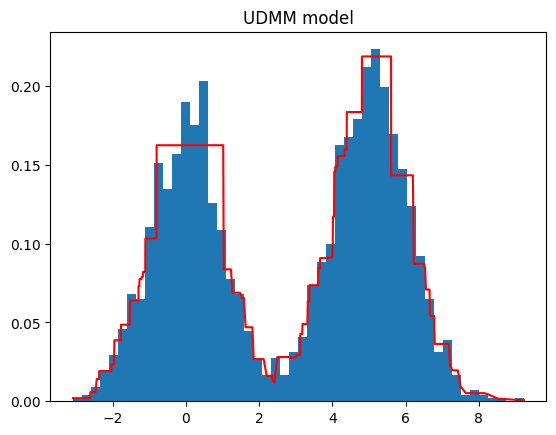

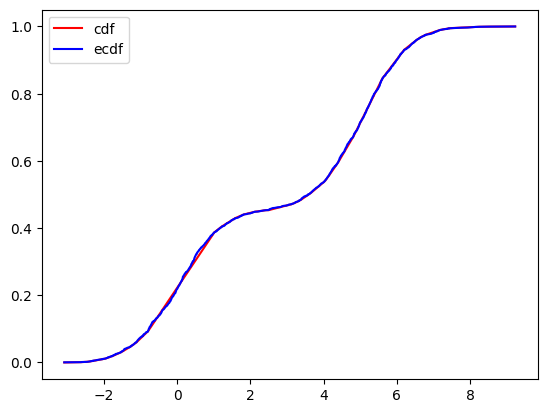

In [55]:
# plot UDMM pdf and UDMM cdf (compared to ecdf)
plt.figure()
plt.hist(X, bins=50, density = True)
plt.plot(X, pdf_val, 'r')
plt.title("UDMM model")
plt.show()

ecdf = ECDF(X)
plt.figure()
plt.plot(X, cdf_val, 'r', label='cdfUU')
plt.plot(ecdf.x, ecdf.y, c='b', label='ecdf')
plt.legend(['cdf','ecdf'])
plt.show()



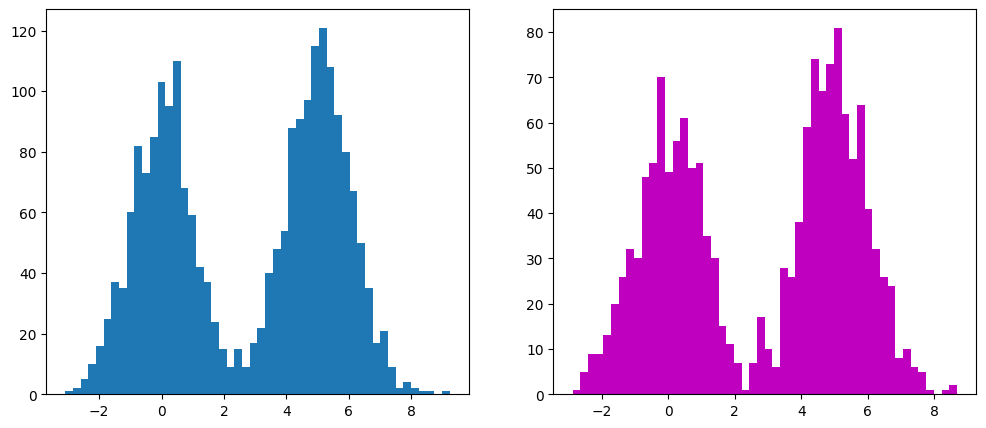

In [56]:
# Generate a sample from the original dataset X following the same multimodal distribution 
samples = sample(X, n=1500)

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.hist(X, bins=50)
plt.subplot(1,2,2)
plt.hist(samples, bins=50, color="m")
plt.show()

### Unimodal data

In [60]:
# Detect cut points using UniSplit algorithm
X = np.random.normal(0,1,1000)

X = X.tolist()
cp_list = UniSplit(X, [])

if cp_list:
    print("The dataset is multimodal\n")
    cp_list_final = merge_unimodal_subsets(X, cp_list)
    print(f"The cut points are: {cp_list_final}\n")

else:
    print("The dataset is unimodal | No cut points exist.\n")
    

The dataset is unimodal | No cut points exist.



In [61]:
# Fit a UDMM to data and compute pdf, cdf
# Since the data X is unimodal, UDMM has a single component, so it corresponds to a UMM (working the same as this in UUtest file)
component_point_ratio, interval_point_ratio, intervals_per_component, component_ranges = fitUU(X)
pdf_val, X = pdfUU(X, component_point_ratio, interval_point_ratio, intervals_per_component, component_ranges)
cdf_val, S = cdfUU(X, component_point_ratio, interval_point_ratio, intervals_per_component, component_ranges)

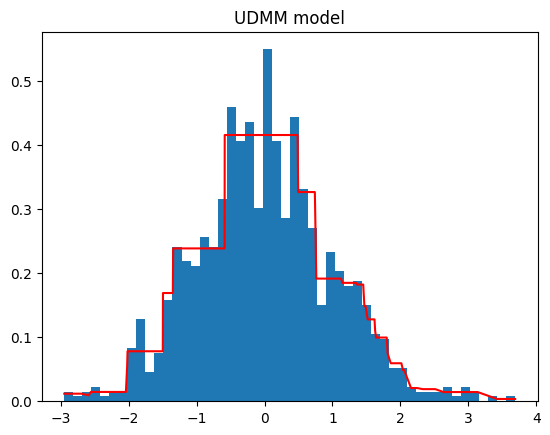

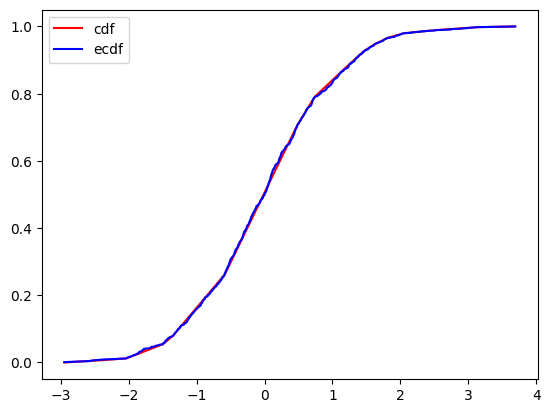

In [62]:
# plot UDMM pdf and UDMM cdf (compared to ecdf)
plt.figure()
plt.hist(X, bins=50, density = True)
plt.plot(X, pdf_val, 'r')
plt.title("UDMM model")
plt.show()

ecdf = ECDF(X)
plt.figure()
plt.plot(X, cdf_val, 'r', label='cdfUU')
plt.plot(ecdf.x, ecdf.y, c='b', label='ecdf')
plt.legend(['cdf','ecdf'])
plt.show()


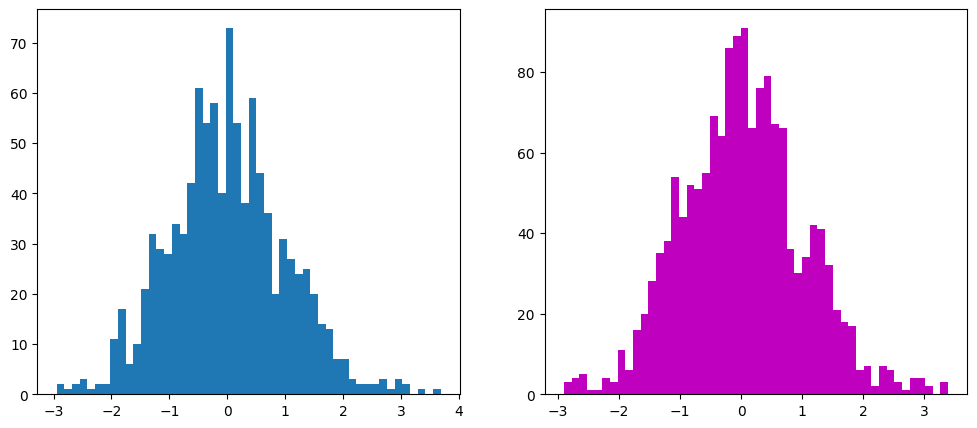

In [63]:
# Generate a sample from the original dataset X following the same multimodal (in this case: unimodal) distribution 
samples = sample(X, n=1500)

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.hist(X, bins=50)
plt.subplot(1,2,2)
plt.hist(samples, bins=50, color="m")
plt.show()